In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils.metrics import validation_scores
from models.x64x64_to_256x256.HVAE import ConditionalHierarchicalVAE
from utils.datasets import Pokemon_SR
from utils.utils import gaussian_kl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 200
batch_size = 8
scalefactor = 4

path = f"E:/GNN/experiments/trained_models/HVAE_POKEMON_{scalefactor}x_prediction_mse.pth"

latent_dims = [128, 256, 512]
condition_dims = [32, 64]
channels = [4,8,16,32,32,32]
#cond_channels = [16, 32]
cond_channels = [32, 64, 128, 256]
in_channels = 3
cond_base_width = 256 // scalefactor
model = ConditionalHierarchicalVAE(in_channels=in_channels,
                          #latent_dims=latent_dims,
                          channels=channels,
                          cond_channels=cond_channels,
                          condition_dims=condition_dims,
                          cond_base_width=cond_base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, cond_base_width, cond_base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, 256, 256), (1, in_channels, cond_base_width, cond_base_width)])

torch.Size([1, 3, 256, 256])


Layer (type:depth-idx)                        Output Shape              Param #
ConditionalHierarchicalVAE                    [1, 3, 256, 256]          --
├─ConditionalHierarchicalEncoder: 1-1         [1, 64]                   --
│    └─Conv2d: 2-1                            [1, 4, 256, 256]          16
│    └─Conv2d: 2-2                            [1, 8, 128, 128]          520
│    └─Conv2d: 2-3                            [1, 16, 64, 64]           2,064
│    └─Conv2d: 2-4                            [1, 32, 32, 32]           8,224
│    └─Conv2d: 2-5                            [1, 32, 16, 16]           16,416
│    └─Conv2d: 2-6                            [1, 32, 8, 8]             16,416
│    └─Linear: 2-7                            [1, 64]                   131,136
│    └─Linear: 2-8                            [1, 64]                   131,136
│    └─Linear: 2-9                            [1, 128]                  1,048,704
│    └─Linear: 2-10                           [1, 128]         

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_dataset = Pokemon_SR(path=r"E:\GNN\gnn\pokemon_white.npy", split="train", device=device)
val_dataset = Pokemon_SR(path=r"E:\GNN\gnn\pokemon_white.npy", split="val", device=device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(val_dataset)} validation samples")

cuda
Dataset Loaded: 655 training samples, 164 validation samples


In [4]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#criterion = PerceptualLoss().to(device)
#criterion = -ssim()
criterion = MSELoss()
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.9)

In [6]:
loss_list = []
recon_loss_list = []
kl_loss_list = []

In [7]:
kl_weight = 500

for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for LR, HR in train_loader:
        optimizer.zero_grad()

        recon_imgs, latents = model(HR, LR)

        recon_loss = criterion(recon_imgs, HR)

        
        kl_loss = 0
        for mu, logvar in latents:
            logvar = torch.clamp(logvar, min=-10.0, max=10.0)
            kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
        #print(kl_loss)
        
        loss = recon_loss + kl_weight * kl_loss
        #print(loss, recon_loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.6f} | Perceptual Loss: {total_recon_loss:.6f} | KL Loss: {total_kl_loss:.6f}")
    loss_list.append(total_loss)
    recon_loss_list.append(total_recon_loss)
    kl_loss_list.append(total_kl_loss)

Epoch [1/200] | Loss: 34964.492916 | Perceptual Loss: 13.730152 | KL Loss: 69.901525
Epoch [2/200] | Loss: 451.692856 | Perceptual Loss: 6.744010 | KL Loss: 0.889898
Epoch [3/200] | Loss: 201.858521 | Perceptual Loss: 5.256665 | KL Loss: 0.393204
Epoch [4/200] | Loss: 125.087085 | Perceptual Loss: 4.843980 | KL Loss: 0.240486
Epoch [5/200] | Loss: 228.371850 | Perceptual Loss: 4.628300 | KL Loss: 0.447487
Epoch [6/200] | Loss: 189.728396 | Perceptual Loss: 4.394189 | KL Loss: 0.370668
Epoch [7/200] | Loss: 161.644512 | Perceptual Loss: 4.547204 | KL Loss: 0.314195
Epoch [8/200] | Loss: 107.057215 | Perceptual Loss: 3.895564 | KL Loss: 0.206323
Epoch [9/200] | Loss: 77.065470 | Perceptual Loss: 3.683682 | KL Loss: 0.146764
Epoch [10/200] | Loss: 254.806949 | Perceptual Loss: 3.350822 | KL Loss: 0.502912
Epoch [11/200] | Loss: 21.458043 | Perceptual Loss: 3.317239 | KL Loss: 0.036282
Epoch [12/200] | Loss: 14.505590 | Perceptual Loss: 3.061432 | KL Loss: 0.022888
Epoch [13/200] | Loss: 5

In [8]:
torch.save(model.state_dict(), path)

In [9]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

[]

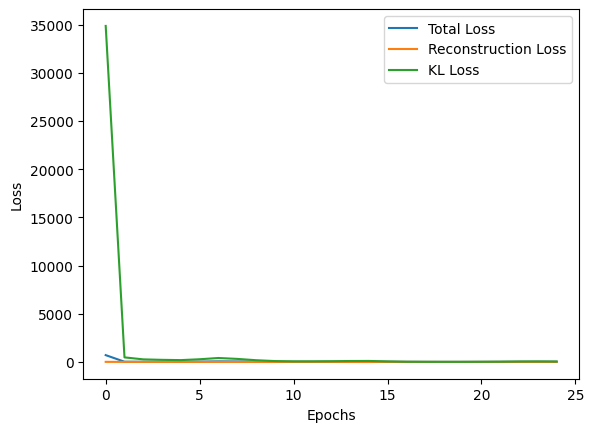

In [ ]:
plt.plot(loss_list[1:], label='Total Loss')
plt.plot(recon_loss_list[1:], label='Reconstruction Loss')
plt.plot([l * kl_weight for l in kl_loss_list][1:], label='KL Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [10]:
HR, LR = val_dataset.get_samples(10)
SR = model.sample(LR)

In [7]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

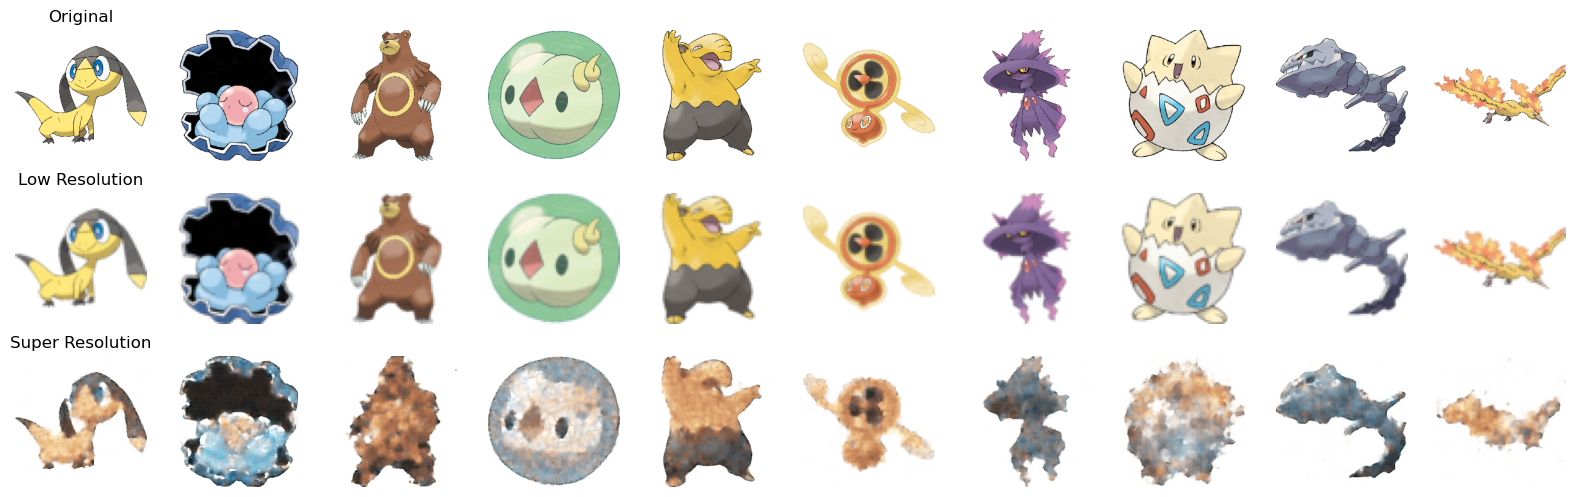

In [13]:
show_image(HR, LR, SR, 10)

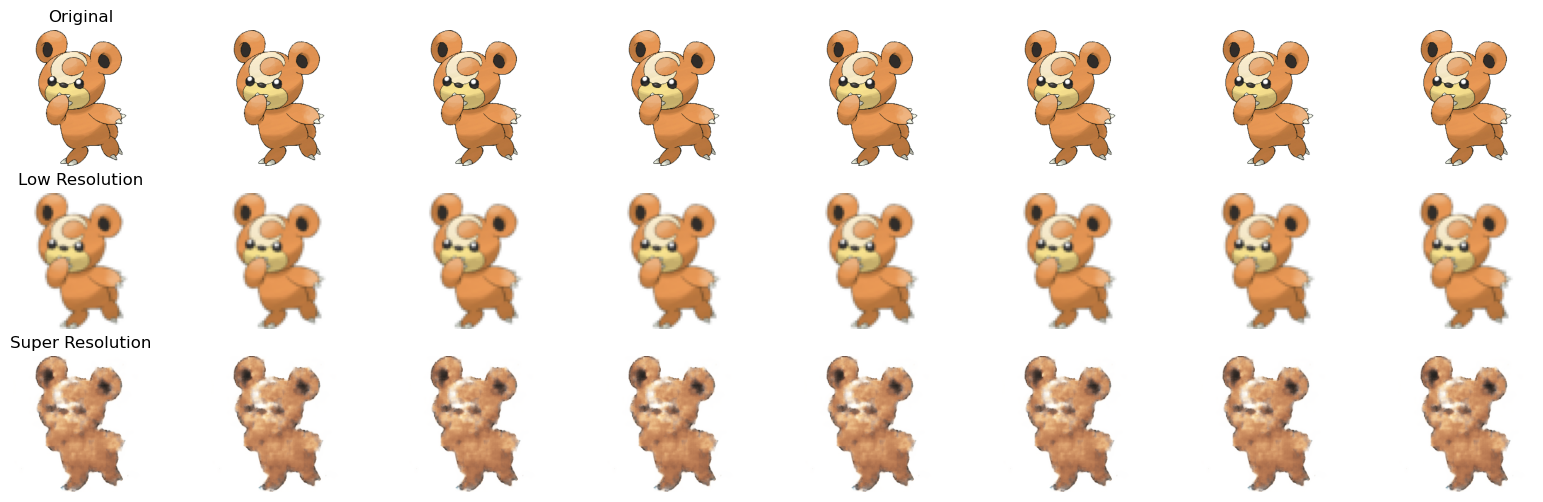

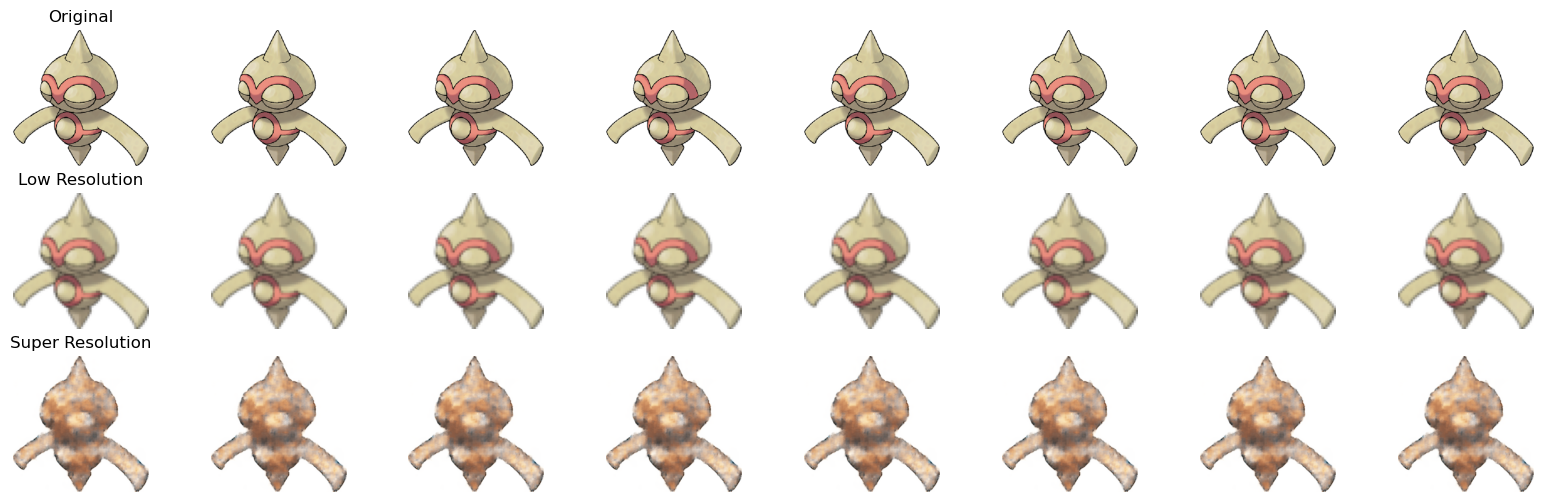

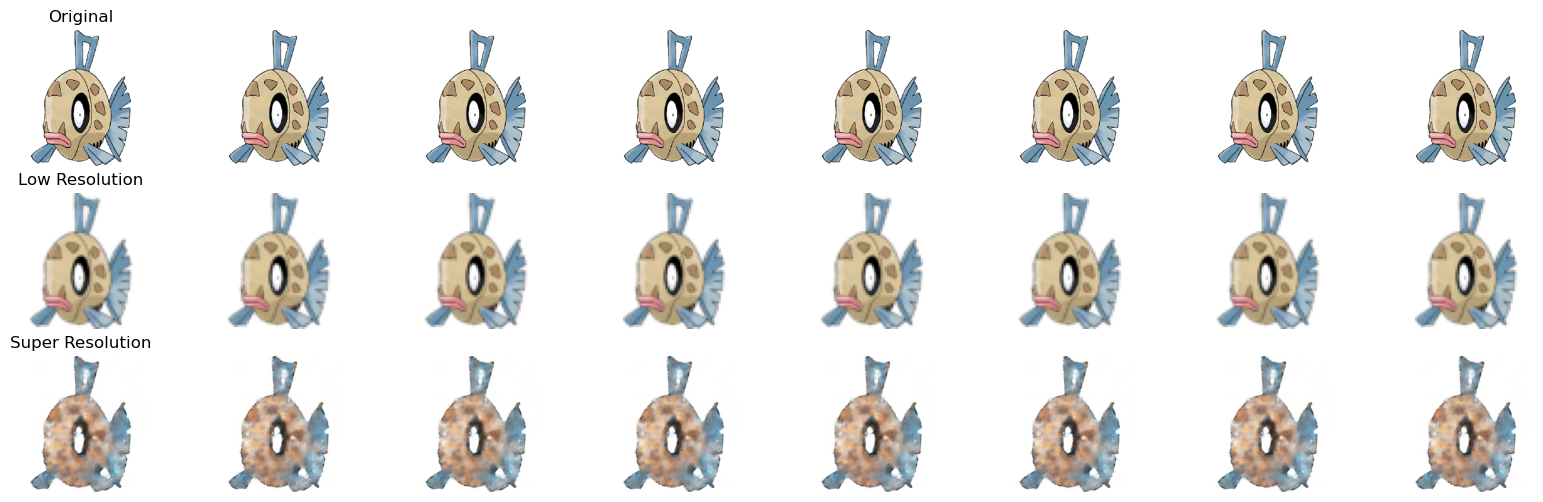

In [11]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 8)

In [13]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)

print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\UniProgramme\anaconda3\envs\isl_segmentation\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\UniProgramme\anaconda3\envs\isl_segmentation\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


32 10
MSE: 0.018888846039772034
Perceptual: 5.1725945472717285
PSNR: 17.5426025390625
SSIM: 0.6737022399902344
LPIPS: 0.3661351501941681
BRISQUE: 40.42755126953125
PSNR Consistency: 22.711647033691406
MSE Diversity: 9.831306024352671e-05
LPIPS Diversity: 0.011599318007938564
